## NF4 

- 正态分布的分位数函数（percent point function，ppf），也就是正态分布的逆累积分布函数。norm.ppf函数接受一个介于0和1之间的概率值，并返回对应的z分数。例如，`norm.ppf(0.975)`将返回大约1.96，因为在标准正态分布下，约有`97.5%`的值小于`1.96`
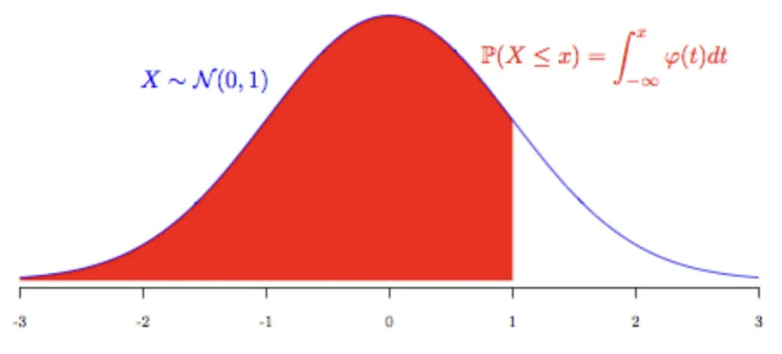
- `torch.linspace(offset, 0.5, n)`函数生成一个等差数列，起始值为offset，终止值为0.5，共有n个元素。这个数列被用作`norm.ppf`函数的输入，生成一组z分数
- `offset`的默认值。在创建正态映射时，他们希望找到的分位数在其左侧和右侧有相等的面积。这意味着他们并不从0或1的分位数开始，而是从一个偏移量（offset）的分位数开始。在这段代码中，`offset`的默认值是$1-1/(2*15)$。这是因为在一个不对称的数据类型中，一侧有等于16个"半"的间隔围绕每个分位数，另一侧有15个"半"。因此 `offset` 的平均值是$(1-1 /(2 * 15)+1-1 /(2 * 16)) / 2=0.9677083$ 
- `use_extra_value`参数决定了映射表中非零值的数量。如果`use_extra_value`为True，映射表中将有15个非零值；否则，将有14个非零值
 

In [3]:
import torch
from scipy.stats import norm

def create_normal_map(offset=0.9677083, use_extra_value=True):

    if use_extra_value:
        # one more positive value, this is an asymmetric type
        v1 = norm.ppf(torch.linspace(offset, 0.5, 9)[:-1]).tolist()
        v2 = [0]*(256-15) ## we have 15 non-zero values in this data type
        v3 = (-norm.ppf(torch.linspace(offset, 0.5, 8)[:-1])).tolist()
        v = v1 + v2 + v3
    else:
        v1 = norm.ppf(torch.linspace(offset, 0.5, 8)[:-1]).tolist()
        v2 = [0]*(256-14) ## we have 14 non-zero values in this data type
        v3 = (-norm.ppf(torch.linspace(offset, 0.5, 8)[:-1])).tolist()
        v = v1 + v2 + v3

    values = torch.Tensor(v)
    values = values.sort().values
    values /= values.max()
    assert values.numel() == 256
    return values

v = create_normal_map()
print(v)

tensor([-1.0000, -0.6962, -0.5251, -0.3949, -0.2844, -0.1848, -0.0911,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [7]:
# bitsandbytes: create_normal_map
offset = 0.9677083
print("----------------P step---------------------")
step_pos = torch.linspace(offset, 0.5, 9)[:-1] #概率区间
step_neg = torch.linspace(offset, 0.5, 8)[:-1]
print("NF step 9: ",step_pos)
print("NF step 8: ",step_neg)

print("----------------norm---------------------")
v1 = norm.ppf(step_pos).tolist()              #得到概率对应的正态分布的分数位
print("NF+:", [f'{num:.4f}' for num in v1])
v2 = [0]
v3 = (-norm.ppf(step_neg)).tolist()
print("NF-:", [f'{num:.4f}' for num in v3])

print("----------------nf4-pre---------------------")
v = v1 + v2 + v3
print("NF4:", [f'{num:.4f}' for num in v])

print("----------------nf4 归一化---------------------")
values = torch.Tensor(v)
values = values.sort().values
values /= values.max()
print("NF4/max:", [f'{num:.4f}' for num in values])

----------------P step---------------------
NF step 9:  tensor([0.9677, 0.9092, 0.8508, 0.7923, 0.7339, 0.6754, 0.6169, 0.5585])
NF step 8:  tensor([0.9677, 0.9009, 0.8341, 0.7673, 0.7004, 0.6336, 0.5668])
----------------norm---------------------
NF+: ['1.8481', '1.3361', '1.0398', '0.8145', '0.6245', '0.4548', '0.2974', '0.1471']
NF-: ['-1.8481', '-1.2867', '-0.9704', '-0.7299', '-0.5257', '-0.3415', '-0.1683']
----------------nf4-pre---------------------
NF4: ['1.8481', '1.3361', '1.0398', '0.8145', '0.6245', '0.4548', '0.2974', '0.1471', '0.0000', '-1.8481', '-1.2867', '-0.9704', '-0.7299', '-0.5257', '-0.3415', '-0.1683']
16
----------------nf4 归一化---------------------
NF4/max: ['-1.0000', '-0.6962', '-0.5251', '-0.3949', '-0.2844', '-0.1848', '-0.0911', '0.0000', '0.0796', '0.1609', '0.2461', '0.3379', '0.4407', '0.5626', '0.7230', '1.0000']


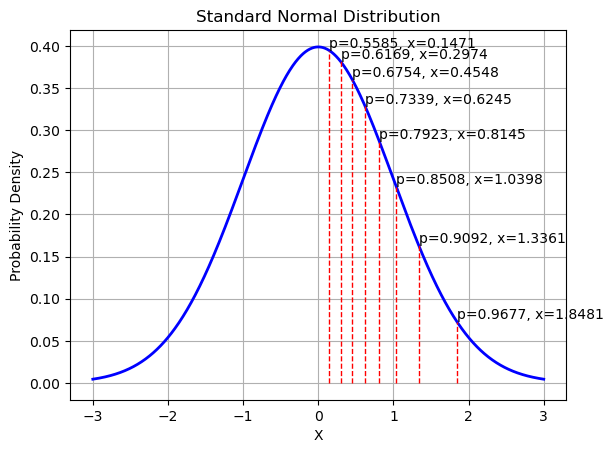

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, 1000)
y = norm.pdf(x, 0, 1)  # 均值为0，标准差为1的正态分布
plt.plot(x, y, 'b-', linewidth=2)
prob_list = torch.linspace(offset, 0.5, 9)[:-1].tolist()
for prob in prob_list:
    x_prob = norm.ppf(prob, 0, 1)  # 根据概率计算对应的横坐标
    y_prob = norm.pdf(x_prob, 0, 1)  # 计算指定概率处的纵坐标
    plt.plot([x_prob, x_prob], [0, y_prob], 'r--', linewidth=1)  
    plt.text(x_prob, y_prob, f'p={prob:.4f}, x={x_prob:.4f}', ha='left', va='bottom') 
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title('Standard Normal Distribution')
plt.grid(True)
plt.show()

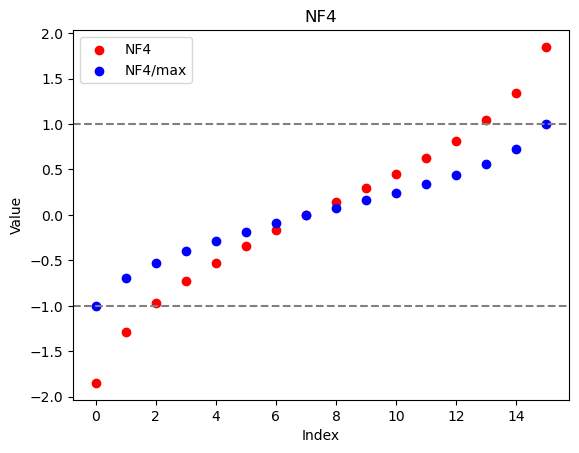

In [6]:
v_tensor = torch.Tensor(v)
v_sort = v_tensor.sort().values
plt.axhline(y=1, color='gray', linestyle='--', )
plt.axhline(y=-1, color='gray', linestyle='--', )
plt.scatter(range(len(v_sort)), v_sort, c='red', label='NF4')
plt.scatter(range(len(values)), values, c='blue', label='NF4/max')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('NF4')
plt.legend()
plt.show()